In [1]:
from google.colab import drive
drive.mount('/content/drive')
!pip install EMD-signal

Mounted at /content/drive
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.4/77.4 KB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 KB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 KB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 16.1 MB/s eta 0:00:00


In [2]:
import sys    
sys_path = '/content/drive/MyDrive/EMG-classification'
sys.path.append(sys_path)
import scipy.signal as spec
import matplotlib.pyplot as plt
import numpy as np
from PyEMD import EEMD
from util import *
from dataloader import *

In [ ]:
#plot raw data
data_path = '/content/drive/MyDrive/EMG-classification/dataset/rawdata/ai_0501.bin'
epoch_time, record_data, signal = readdata(data_path)
#
# plt.plot(signal[1200*804:1200*805+1])
# plt.show()
# a = timetoepoch(time[index],1200)

win = s.get_window('hann',100)
# a, b, c = signal.stft(signal, 1200, window=win, nperseg=100, noverlap=80, nfft=256)

# f, t, Sxx = s.spectrogram(signal[1200*499:1200*500+1], 1200, window=win, nperseg=100, noverlap=80, nfft=256)
# print("what is f?{}".format(f))
# print("freq:{}\ntime:{}\nspectro:{}\n".format(f.shape, t.shape, Sxx.shape))
time, raw, spectrogram_norm, spectrogram_std = normspectro(data_path, 100, 256, 0, 100)
spctr = spectrogram_norm[500]

plt.figure()
plt.subplot(211)
# print("freq:{}\ntime:{}\nspectro:{}\n".format(raw.shape, time.shape, spectrogram_norm.shape))
# print("what is the 'raw'?{}".format(raw))
plt.pcolormesh(time/1200, raw, spctr, shading='gouraud')
plt.rcParams['figure.dpi'] = 300
spctr[:5,:] = 0
plt.subplot(212)
plt.pcolormesh(time/1200, raw, spctr, shading='gouraud')
plt.plot()
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

In [3]:
def normspectr(datapath,length_of_win,fft_length,start,end):
    # normspectro(data_path, 100, 256, 0, 100)
    epoch_time, record_data, signal = readdata(datapath)
    # len(signal) == record_data.shape[0] * record_data.shape[1]
    print("Record data shape:{}\n".format(record_data.shape))
    fs = 1200
    win = spec.get_window('hann', length_of_win) # the number of samples in the window// win:ndarray[length_of_win]
    norm_signal = []
    for i in range(start, end):
        [f, t, stft_signal] = spec.spectrogram(signal[i*1200:(i+1)*1200], fs,
                                    window=win,
                                    nperseg=length_of_win,
                                    noverlap=0.8*length_of_win,
                                    nfft = fft_length)
        stft_signal = abs(stft_signal)
        norm_signal.append(stft_signal)
    norm_signal = np.hstack(norm_signal)
    reference_mean_norm = 10*np.log10(np.mean(norm_signal,axis = 1))
    reference_std_norm = np.std(norm_signal,axis = 1)
    raw = []
    spectrogram_mean = []
    spectrogram_std = []
    for i in range(record_data.shape[0]):
        [f, t, stft_signal] = spec.spectrogram(signal[i*1200:(i+1)*1200+1],fs,
                                    window = win,
                                    nperseg = length_of_win,
                                    noverlap = 0.8*length_of_win,
                                    nfft = fft_length)
        raw.append(10*np.log10(abs(stft_signal)))
        s_mean = 10*np.log10(abs(stft_signal)) - np.tile(reference_mean_norm,(abs(stft_signal).shape[1],1)).T
        s_std = abs(stft_signal) - np.tile(reference_std_norm,(abs(stft_signal).shape[1],1)).T
        spectrogram_mean.append(s_mean)
        spectrogram_std.append(s_std)
    raw = np.asarray(raw)
    spectrogram_mean = np.asarray(spectrogram_mean)
    spectrogram_std = np.asarray(spectrogram_std)
    return t*1200, f, spectrogram_mean, spectrogram_std # raw

In [4]:
data_path = '/content/drive/MyDrive/EMG-classification/dataset/rawdata/ai_0501.bin'
epoch_time, record_data, signal = readdata(data_path)
_, raw, spectrogram_norm, spectrogram_std = normspectr(data_path, 100, 256, 0, 100)

channel_number:1
total_record:5746

channel_number:1
total_record:5746

Record data shape:(5746, 1200)



EEMD shape:(2, 1201)



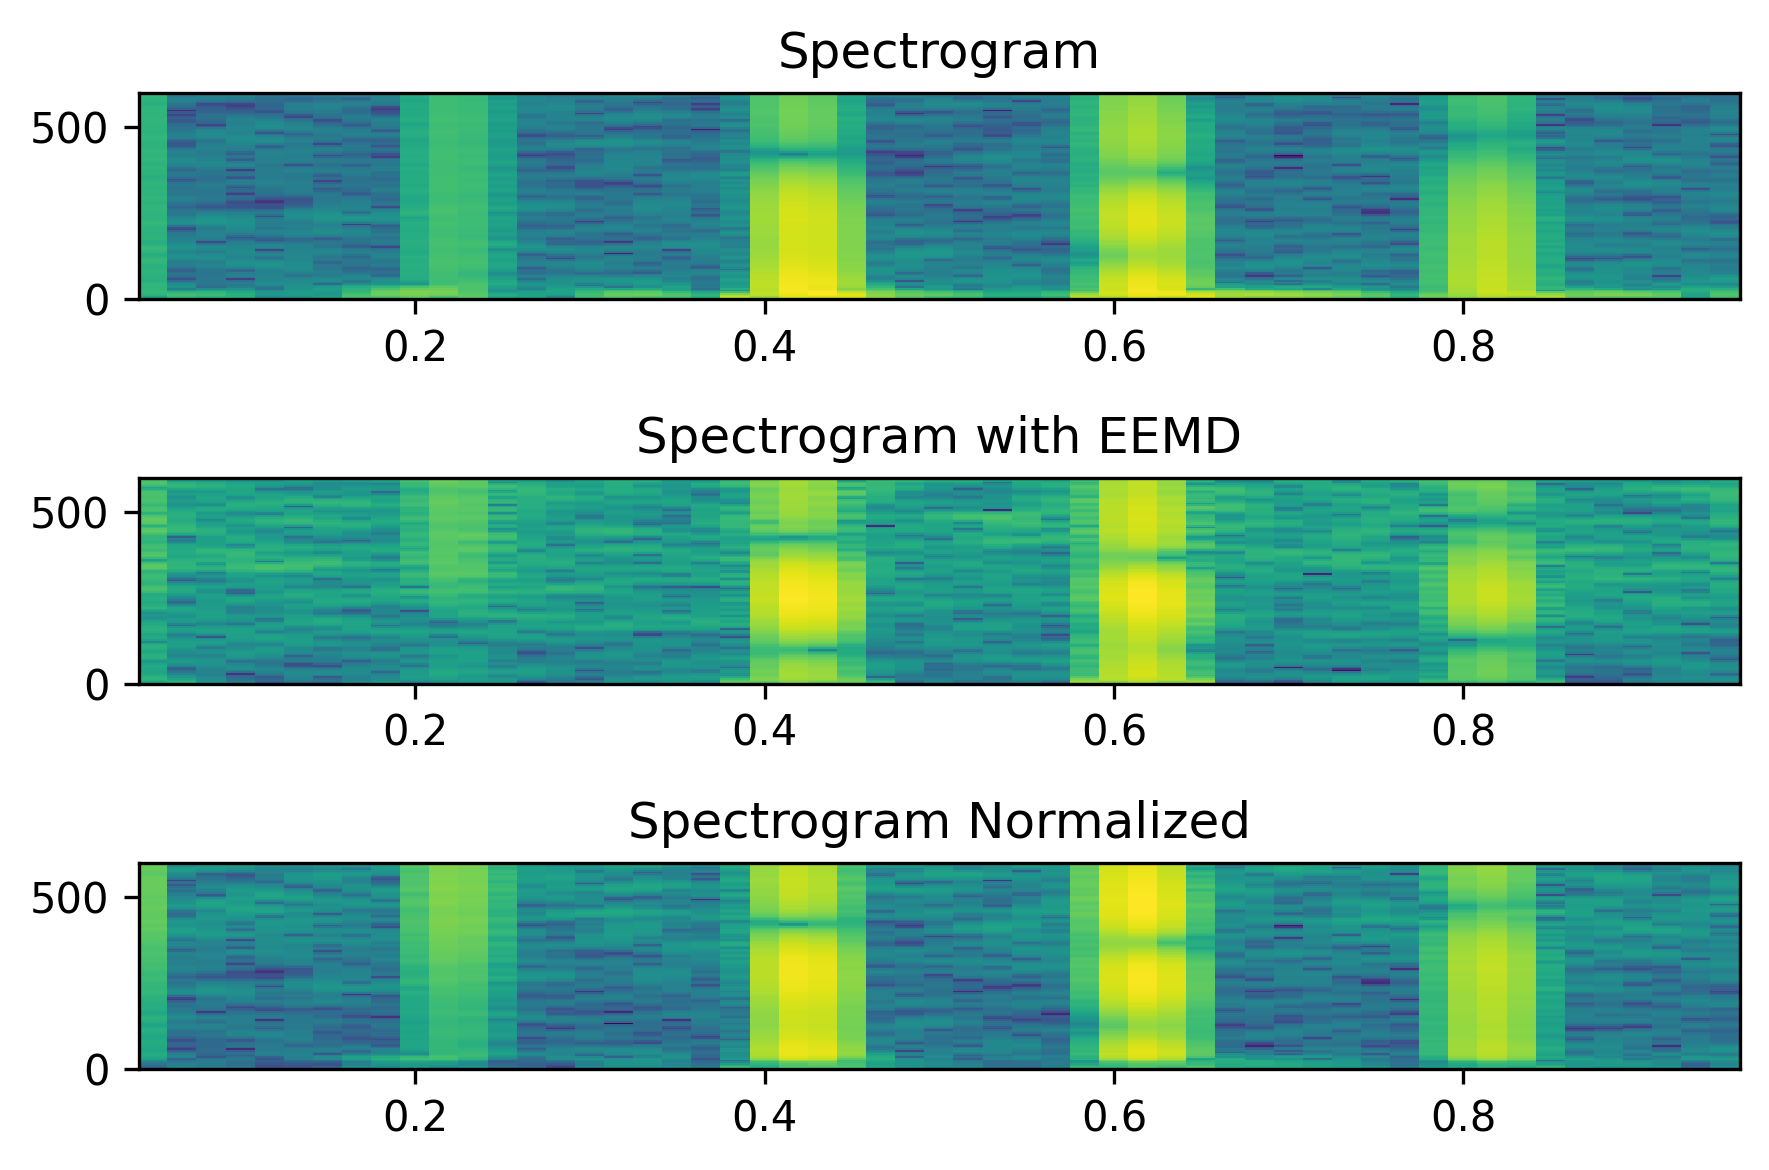

In [14]:
# EEMD spectrogram plotting
idx = 2050
s = signal[1200*idx: 1200*(idx+1)+1]
data = record_data[idx:idx+1]

[f, time, stft_signal] = spec.spectrogram(s, 1200,
                            window=spec.get_window('hann',100),
                            nperseg=100,
                            noverlap=0.8*100,
                            nfft = 256)

spctr = spectro(data, s, 100, 256)
spctr = torch.from_numpy(spctr).squeeze()

eemd = EEMD()
eIMFs = eemd.eemd(s)
spctr_eemd = spectro(data, eIMFs[0], 100, 256)
spctr_eemd = torch.from_numpy(spctr_eemd).squeeze()
print("EEMD shape:{}\n".format(eIMFs.shape))
# print("spectrogtam shape:{}\nseemd_spectrogtam shape:{}\n".format(spctr.shape, spctr_eemd.shape))

spctr_norm = spectrogram_norm[idx]

# spctr_eemd1 = spectro(data, eIMFs[1], 100, 256)
# spctr_eemd1 = torch.from_numpy(spctr_eemd1).squeeze()

plt.figure()
plt.subplot(311)
plt.pcolormesh(time, raw, spctr)
# plt.colorbar(im)
plt.rcParams['figure.dpi'] = 300
plt.gca().set_title('Spectrogram')
plt.subplot(312)
plt.pcolormesh(time, raw, spctr_eemd)
plt.gca().set_title('Spectrogram with EEMD')
plt.subplot(313)
# plt.pcolormesh(time, raw, spctr_eemd1)
# plt.gca().set_title('Spectrogram with EEMD -1')
# plt.subplot(313)
plt.pcolormesh(time, raw, spctr_norm)
plt.gca().set_title('Spectrogram Normalized')
plt.plot()
# plt.ylabel('Frequency [Hz]')
# plt.xlabel('Time [sec]')
plt.tight_layout()
plt.show()